### 数据处理
1. 提取文本的最后两列

In [22]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 26 16:57:43 2018

@author: Administrator
"""

from numpy import *
'''
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = map(float,curLine) #map all elements to float()
        A=list(fltLine) #与2.x区别
        dataMat.append(A)
    return dataMat
'''
def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2)))

#随机生成簇中心函数
# 生成 K×N ： centroids, 每行即为一个中心点
def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))
    for j in range(n):
        minJ = min(dataSet[:,j]) 
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = mat(minJ + rangeJ * random.rand(k,1))
    return centroids

#dataSet为数据集，k为分簇数目，distEclud为距离函数，randCent为随机选择簇中心方法
def kMeans(dataSet, k, distMeas=distSLC, createCent=randCent):
    m = shape(dataSet)[0]
    #初始化矩阵clusterAssment，第1列记录簇索引值，第2列存储误差
    clusterAssment = mat(zeros((m,2)))  
    
    #初始化簇中心                            
    centroids = createCent(dataSet, k)
    
    #标志变量，用于判断是否继续迭代
    clusterChanged = True
    
    while clusterChanged:
        clusterChanged = False
    #将每个样本点分配到与其最近的簇中心所在的簇
        for i in range(m): 
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
    #如果样本被划分到不同的簇，则改变标志变量，表示需要继续迭代
            if clusterAssment[i,0] != minIndex:
                clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
    #打印簇中心
        #print (centroids)
    #由于样本划分发生变化，因此需要重新计算簇中心
        for cent in range(k):
    #提取处属于同一簇的所有样本
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]
    #计算不同簇所有样本的平均值作为簇中心
            centroids[cent,:] = mean(ptsInClust, axis=0) 
    return centroids, clusterAssment

#dataSet为数据集，k为分簇数目，distEclud为距离函数
def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    #将所有样本的均值作为簇中心
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    #创建簇中心列表
    centList =[centroid0] 
    #计算每个样本的误差
    for j in range(m):
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
    #拆分每个簇，并计算拆分后的SSE，选择拆分后SSE最小的簇，保存拆分
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            #print ("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
    #一个簇拆分为二后，其中一个簇新增加簇索引，另一个保存原簇索引号
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) 
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        #print ('the bestCentToSplit is: ',bestCentToSplit)
        #print ('the len of bestClustAss is: ', len(bestClustAss))
    #重置簇中心
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]
        centList.append(bestNewCents[1,:].tolist()[0])
    #调整样本的簇索引号及误差
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss
    return mat(centList), clusterAssment

#根据经纬度计算球面距离，vecA[0,：]表示A点经纬度
def distSLC(vecA, vecB):
    a = sin(vecA[0,1]*pi/180) * sin(vecB[0,1]*pi/180)
    b = cos(vecA[0,1]*pi/180) * cos(vecB[0,1]*pi/180) * \
                      cos(pi * (vecB[0,0]-vecA[0,0]) /180)
    return arccos(a + b)*6371.0 

import matplotlib
import matplotlib.pyplot as plt
#numClust为簇数目
def clusterClubs(numClust=5, bi = True):
    datList = []
    #导入数据
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = mat(datList)
    #采用二分k-均值算法进行聚类
    if bi == False:
        myCentroids, clustAssing = kMeans(datMat, numClust, distMeas=distSLC)
    elif bi == True:
        myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    #定义画布，背景
    fig = plt.figure()
    rect=[0.0,0.0,1.0,1.0]
    #不同图形标识
    scatterMarkers=['s', 'o', '^', '8', 'p', \
                    'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0=fig.add_axes(rect, label='ax0', **axprops)
    #导入地图
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    #采用不同图形标识不同簇
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
    #采用‘+’表示簇中心
    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()

/home/yangchonghuan/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:536: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/yangchonghuan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


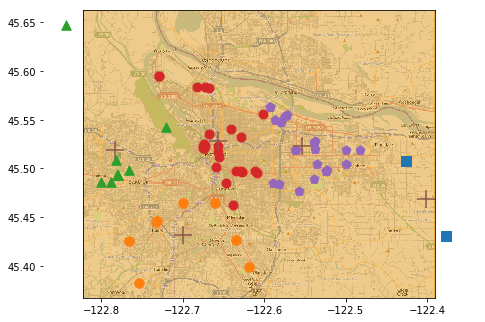

In [25]:
clusterClubs(numClust=5)

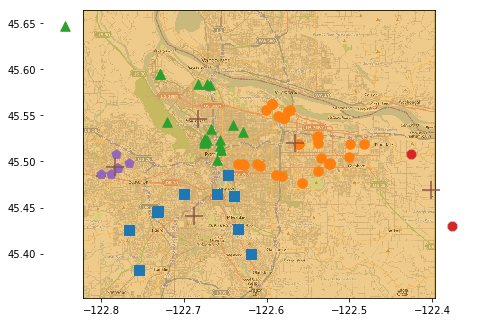

In [28]:
clusterClubs(numClust=5,bi = False)

In [21]:
from numpy import *
random.rand(3,1).shape

(3, 1)